In [1]:
#!pip install matplotlib

In [1]:
import numpy as np
import torch
import torch.nn as nn
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt

[16-01 트랜스포머(Transformer)](https://wikidocs.net/31379) 내용을 참고함.  
트랜스포머의 내부를 이해하기 전 우선 트랜스포머의 입력에 대해서 알아보겠습니다.  
RNN이 자연어 처리에서 유용했던 이유는 단어의 위치에 따라 단어를 순차적으로 입력받아서   
처리하는 RNN의 특성으로 인해 각 단어의 위치 정보(position information)를 가질 수   
있다는 점에 있었습니다.

하지만 트랜스포머는 단어 입력을 순차적으로 받는 방식이 아니므로 단어의 위치 정보를  
다른 방식으로 알려줄 필요가 있습니다. 트랜스포머는 단어의 위치 정보를 얻기 위해서  
각 단어의 임베딩 벡터에 위치 정보들을 더하여 모델의 입력으로 사용하는데,  
이를 포지셔널 인코딩(positional encoding)이라고 합니다.  
![그림1](../images/transformer5_final_final.png)

위의 그림은 입력으로 사용되는 임베딩 벡터들이 트랜스포머의 입력으로 사용되기 전에   
포지셔널 인코딩의 값이 더해지는 것을 보여줍니다. 임베딩 벡터가 인코더의 입력으로  
사용되기 전 포지셔널 인코딩값이 더해지는 과정을 시각화하면 아래와 같습니다.  
![그림2](../images/transformer6_final.png)

포지셔널 인코딩 값들은 어떤 값이기에 위치 정보를 반영해줄 수 있는 것일까요? 트랜스포머는  
위치 정보를 가진 값을 만들기 위해서 아래의 두 개의 함수를 사용합니다. 

$ PE(pos,2i) = sin(pos/10000^{\frac{2i}{d_{model}}})$  
$ PE(pos,2i+i) = cos(pos/10000^{\frac{2i}{d_{model}}})$  


사인 함수와 코사인 함수의 그래프를 상기해보면 요동치는 값의 형태를 생각해볼 수 있는데, 트랜스포머는  
사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해주므로서 단어의 순서 정보를 더하여 줍니다.   
그런데 위의 두 함수에는 $pos,i, d_{model}$ 등의 생소한 변수들이 있습니다. 위의 함수를 이해하기 위해서는  
위에서 본 임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 행렬과  
포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다는 점을 이해해야 합니다.  
![그림3](../images/transformer7.png)

$pos$는 입력 문장에서의 임베딩 벡터의 위치(문장의 순서)를 나타내며, $i$는 임베딩 벡터 내의 차원의 인덱스를  
의미합니다. 위의 식에 따르면 임베딩 벡터 내의 각 차원의 인덱스가 짝수인 경우에는 사인 함수의 값을  
사용하고 홀수인 경우에는 코사인 함수의 값을 사용합니다. 위의 수식에서 $(pos, 2i)$일 때는 사인 함수를 사용하고,   
$(pos,2i+1)$일 때는 코사인 함수를 사용하고 있음을 주목합시다.

또한 위의 식에서 $d_{model}$은 트랜스포머의 모든 층의 출력 차원을 의미하는 트랜스포머의  
하이퍼파라미터입니다. 앞으로 보게 될 트랜스포머의 각종 구조에서 $d_{model}$의 값이 계속해서  
등장하는 이유입니다. 임베딩 벡터 또한 $d_{model}$의 차원을 가지는데 위의 그림에서는 마치 5로 표현되었지만  
실제 논문에서는 512의 값을 가집니다.

위와 같은 포지셔널 인코딩 방법을 사용하면 순서 정보가 보존되는데, 예를 들어 각 임베딩 벡터에  
포지셔널 인코딩의 값을 더하면 같은 단어라고 하더라도 문장 내의 위치에 따라서 트랜스포머의   
입력으로 들어가는 임베딩 벡터의 값이 달라집니다. 이에 따라 트랜스포머의 입력은 순서 정보가  
고려된 임베딩 벡터가 됩니다. 이를 코드로 구현하면 아래와 같습니다.



구현 코드는   
https://colab.research.google.com/drive/1-B8obSiAgAcq-VEJBVVzKIijySDRwm3k?usp=sharing#scrollTo=YnVque8aXKlI  
를 참고함. 

In [3]:
d_model = 128
seq_len = 100
n_batch = 1

In [4]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [5]:
pe = PositionalEncoding(d_model, 0)

In [6]:
pe.pe.shape

torch.Size([1, 5000, 128])

미리 $ n\_batch(1) \times max\_len(5000) \times d_{model}(128)$ 크기로 positional encoding table을 만들어 놓음. 

In [7]:
X = Variable(torch.rand(n_batch, seq_len, d_model))

In [8]:
X.size(1)

100

50 × 128의 크기를 가지는 포지셔널 인코딩 행렬을 시각화하여 어떤 형태를 가지는지 확인해봅시다.  
이는 입력 문장의 단어가 50개이면서, 각 단어가 128차원의 임베딩 벡터를 가질 때 사용할 수 있는 행렬입니다.

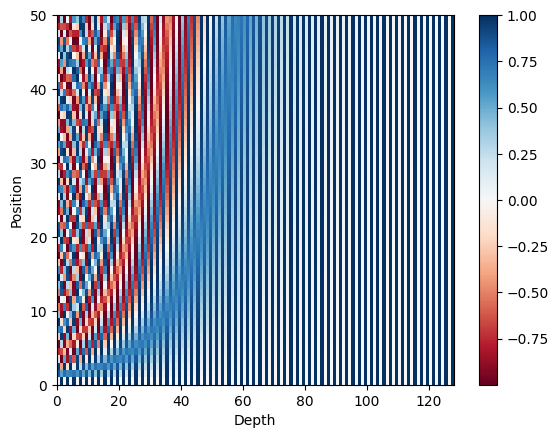

In [9]:
plt.pcolormesh(pe.pe.numpy()[0,:50], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [10]:
y = pe(X)

embedding vector에 positional encoding을 적용한 결과임.

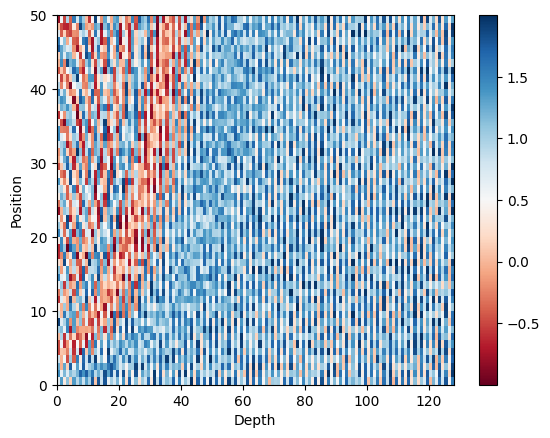

In [11]:
plt.pcolormesh(y.numpy()[0,:50], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()